### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
current_palette = sns.color_palette()
from timeit import default_timer as timer

from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc

import pickle
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")



### Load the pre-processed data file

In [2]:
mfcc_data = pickle.load(open('mfcc_data1.p', 'rb'))

In [3]:
mfcc_data.head()

,features,shape,label,fold,label_id
0,"[[-402.7856750488281, 92.73365020751953, 19.38...","(1, 217)",dog_bark,1,3
1,"[[-366.4703674316406, 126.4369125366211, 31.17...","(1, 217)",dog_bark,1,3
2,"[[-421.5273742675781, 69.03862762451172, 11.25...","(1, 217)",dog_bark,1,3
3,"[[-253.19757080078125, 99.43791961669922, -42....","(1, 217)",dog_bark,1,3
4,"[[-383.81011962890625, 128.45155334472656, 29....","(1, 217)",gun_shot,1,6


In [4]:
a=mfcc_data.groupby('label')
a.mean()

,fold,label_id
label,,
air_conditioner,5.500000,0
car_horn,5.130841,1
children_playing,5.500000,2
dog_bark,5.500000,3
drilling,5.500000,4
engine_idling,5.399000,5
gun_shot,5.446524,6
jackhammer,5.062000,7
siren,5.204521,8


In [5]:
mfcc_data.shape

(8731, 5)

In [6]:
# Use ravel to convert the features column to 1-D array, add sample column and delete featires column.
feat_array = [mfcc_data['features'][i].ravel() for i in range(mfcc_data.shape[0])]
mfcc_data['feature_data'] = pd.Series(feat_array, index=mfcc_data.index)

In [7]:
print(mfcc_data.columns)
print(mfcc_data.shape)

Index(['features', 'shape', 'label', 'fold', 'label_id', 'feature_data'], dtype='object')
(8731, 6)


In [8]:
mfcc_data.head()

,features,shape,label,fold,label_id,feature_data
0,"[[-402.7856750488281, 92.73365020751953, 19.38...","(1, 217)",dog_bark,1,3,"[-402.7856750488281, 92.73365020751953, 19.382..."
1,"[[-366.4703674316406, 126.4369125366211, 31.17...","(1, 217)",dog_bark,1,3,"[-366.4703674316406, 126.4369125366211, 31.174..."
2,"[[-421.5273742675781, 69.03862762451172, 11.25...","(1, 217)",dog_bark,1,3,"[-421.5273742675781, 69.03862762451172, 11.259..."
3,"[[-253.19757080078125, 99.43791961669922, -42....","(1, 217)",dog_bark,1,3,"[-253.19757080078125, 99.43791961669922, -42.0..."
4,"[[-383.81011962890625, 128.45155334472656, 29....","(1, 217)",gun_shot,1,6,"[-383.81011962890625, 128.45155334472656, 29.3..."


In [9]:
mfcc_data['fold'].value_counts()

4     990
5     936
3     925
2     888
1     872
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

In [10]:
mfcc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8731 entries, 0 to 8730
Data columns (total 6 columns):
features        8731 non-null object
shape           8731 non-null object
label           8731 non-null object
fold            8731 non-null int64
label_id        8731 non-null int32
feature_data    8731 non-null object
dtypes: int32(1), int64(1), object(4)
memory usage: 375.2+ KB


In [11]:
drop_cols = ['shape','label_id','fold','features']
mfcc_df = mfcc_data.drop (drop_cols, axis=1)

mfcc_df.head()

,label,feature_data
0,dog_bark,"[-402.7856750488281, 92.73365020751953, 19.382..."
1,dog_bark,"[-366.4703674316406, 126.4369125366211, 31.174..."
2,dog_bark,"[-421.5273742675781, 69.03862762451172, 11.259..."
3,dog_bark,"[-253.19757080078125, 99.43791961669922, -42.0..."
4,gun_shot,"[-383.81011962890625, 128.45155334472656, 29.3..."


In [12]:
mfcc_df.columns

Index(['label', 'feature_data'], dtype='object')

In [13]:
feature_df = list(mfcc_data['feature_data'])
feature_df = pd.DataFrame(feature_df)
data_cols = feature_df.columns

feature_df['label'] = mfcc_data['label']
print('working df shape:', feature_df.shape)


working df shape: (8731, 218)


In [14]:
# Convert label to class number
le = LabelEncoder()
label_id = le.fit_transform(feature_df["label"])

# one hot encode
ohe = OneHotEncoder()
onehot = ohe.fit_transform(label_id.reshape(-1, 1))

for i in range(10):
    feature_df[le.classes_[i]] = onehot[:,i].toarray()

In [15]:
feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,-402.785675,92.733650,19.382502,-13.098002,-5.988058,2.662207,-15.008116,-7.915385,-9.553994,-6.019916,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-366.470367,126.436913,31.174053,-23.376110,-13.181026,0.684522,-27.094633,-19.214334,-22.217587,-9.954311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-421.527374,69.038628,11.259903,-1.287744,2.871704,2.559121,-8.582845,-2.753539,-2.944310,-1.045367,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-253.197571,99.437920,-42.032764,-13.843610,-9.055076,-6.101551,1.607488,-0.437223,7.403707,5.523297,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-383.810120,128.451553,29.313246,18.846985,-6.675448,0.989596,-3.282265,6.314259,2.187165,5.393113,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Create Train and Test datasets

In [16]:
X = feature_df.loc[:,data_cols]
Y = feature_df[feature_df.columns[-10:]]

In [17]:
test_preds = {}
X_train = X[0:7078].values
X_test = X[7078:].values
y_train = Y[0:7078].values
y_test = Y[7078:].values



In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7078, 217), (1653, 217), (7078, 10), (1653, 10))

In [19]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model Evaluation

#### Model 1: Multilayer Preceptron

In [20]:
#forming model
model=Sequential()

In [21]:
#building the model
model.add(Dense(units=217,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=108,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=54,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode = 'auto', verbose = 1, patience = 10)

In [23]:
#fitting
model.fit(X_train,y_train,epochs=60,validation_data=(X_test,y_test), callbacks=[early_stop])

Train on 7078 samples, validate on 1653 samples
Epoch 1/60
7078/7078 [==============================] - 1s 150us/sample - loss: 2.2824 - acc: 0.1852 - val_loss: 1.8719 - val_acc: 0.3938
Epoch 2/60
7078/7078 [==============================] - 1s 108us/sample - loss: 1.8385 - acc: 0.3589 - val_loss: 1.5139 - val_acc: 0.4852
Epoch 3/60
7078/7078 [==============================] - 1s 175us/sample - loss: 1.5416 - acc: 0.4724 - val_loss: 1.2982 - val_acc: 0.5898
Epoch 4/60
7078/7078 [==============================] - 1s 163us/sample - loss: 1.3180 - acc: 0.5622 - val_loss: 1.2130 - val_acc: 0.6146
Epoch 5/60
7078/7078 [==============================] - 1s 101us/sample - loss: 1.1972 - acc: 0.6177 - val_loss: 1.2472 - val_acc: 0.6364
Epoch 6/60
7078/7078 [==============================] - 2s 238us/sample - loss: 1.0757 - acc: 0.6537 - val_loss: 1.2181 - val_acc: 0.6425
Epoch 7/60
7078/7078 [==============================] - 1s 125us/sample - loss: 1.0263 - acc: 0.6835 - val_loss: 1.1939 - va

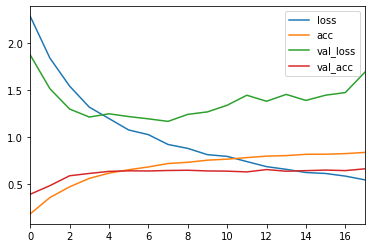

In [24]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [31]:
score = model.evaluate(X_test, y_test, batch_size=128)

1653/1653 [==============================] - 0s 40us/sample - loss: 1.6900 - acc: 0.6636


In [25]:
predictions = model.predict_classes(X_test)

In [26]:
predictions

array([4, 4, 4, ..., 7, 4, 4], dtype=int64)

### Run sample test prediction

In [27]:
X_sample = feature_df.loc[:,data_cols]
Y_actual = feature_df[feature_df.columns[-11:]]
X_sample = X_sample.iloc[[7078]]
Y_actual = Y_actual.iloc[[7078]]
X_sample.head()

Y_actual.head()

,label,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
7078,air_conditioner,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
Y_predict = model.predict_classes(X_sample)

In [29]:
Y_predict

array([3], dtype=int64)